In [1]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [53]:
import pandas as pd
from src.load_data import load_data
import src.eda
import importlib
importlib.reload(src.eda)
from src.eda import summarize, missing_check, get_variable_types, plot_correlations, plot_distributions, plot_boxplots, skew_check
import numpy as np

In [3]:
# load data
df = load_data("data/airbnb_df.csv")

print(summarize(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3982 entries, 0 to 3981
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   listing_id           3982 non-null   int64  
 1   property_type        3982 non-null   object 
 2   number_of_bedrooms   3982 non-null   int64  
 3   guest_capacity       3982 non-null   int64  
 4   location_score       3982 non-null   float64
 5   review_score         3982 non-null   float64
 6   amenities_count      3982 non-null   int64  
 7   host_response_time   3982 non-null   object 
 8   season               3982 non-null   object 
 9   minimum_stay_nights  3982 non-null   int64  
 10  years_as_host        3982 non-null   float64
 11  cleaning_fee         3982 non-null   float64
 12  cancellation_policy  3982 non-null   object 
 13  nightly_rate         3982 non-null   float64
dtypes: float64(5), int64(5), object(4)
memory usage: 435.7+ KB
None
          listing_id  nu

In [4]:
df.head()

,listing_id,property_type,number_of_bedrooms,guest_capacity,location_score,review_score,amenities_count,host_response_time,season,minimum_stay_nights,years_as_host,cleaning_fee,cancellation_policy,nightly_rate
0,100822,Standard Apartment,2,4,75.17,4.87,8,within an hour,peak,2,1.6,21.43,flexible,187.29
1,100908,Standard Apartment,2,3,67.07,4.06,6,>24 hours,off-peak,2,4.1,38.30,flexible,255.64
2,101850,Standard Apartment,1,2,76.57,4.16,10,same day,off-peak,1,2.3,50.34,flexible,62.82
3,102385,Standard Apartment,2,2,88.14,3.74,11,same day,shoulder,2,1.6,35.37,strict,203.80
4,103827,Luxury Home,4,4,58.63,3.37,15,same day,peak,4,0.9,94.90,strict,1000.00


In [5]:
# check missing value
missing_check(df)

listing_id             0
property_type          0
number_of_bedrooms     0
guest_capacity         0
location_score         0
review_score           0
amenities_count        0
host_response_time     0
season                 0
minimum_stay_nights    0
years_as_host          0
cleaning_fee           0
cancellation_policy    0
nightly_rate           0
dtype: int64

In [21]:
# classify variable types
num_cols, cat_cols = get_variable_types(df, "nightly_rate", "listing_id", 0) 
print(f'Numerical columns: {num_cols}')
print(f'Categorical columns: {cat_cols}')
target = df["nightly_rate"]
id_col = df["listing_id"]

Numerical columns: ['number_of_bedrooms', 'guest_capacity', 'location_score', 'review_score', 'amenities_count', 'minimum_stay_nights', 'years_as_host', 'cleaning_fee']
Categorical columns: ['property_type', 'host_response_time', 'season', 'cancellation_policy']


### Numerical Columns

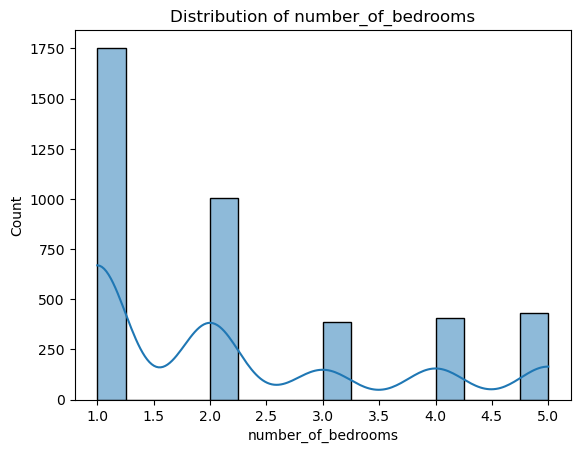

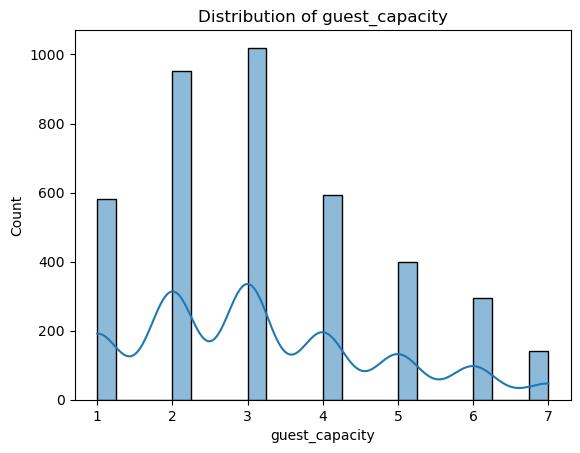

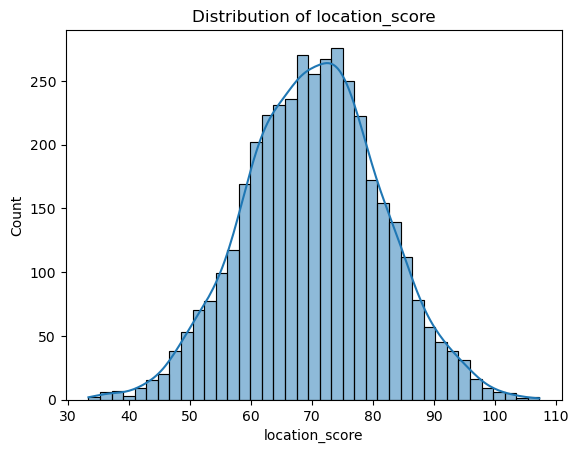

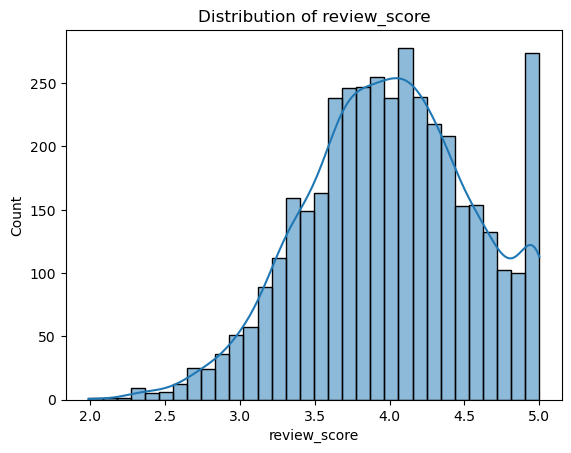

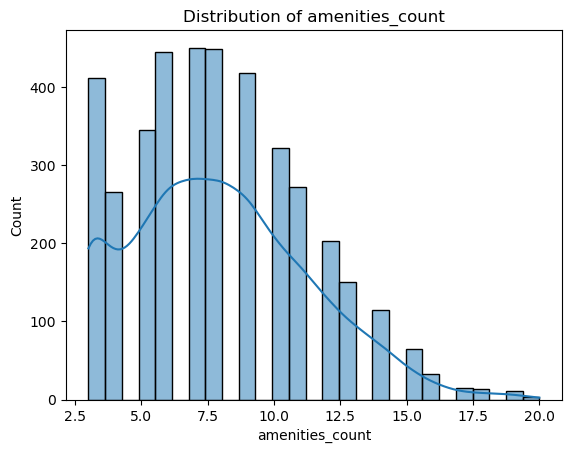

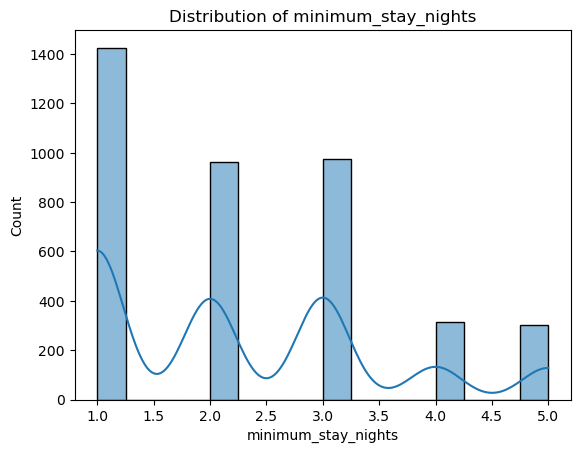

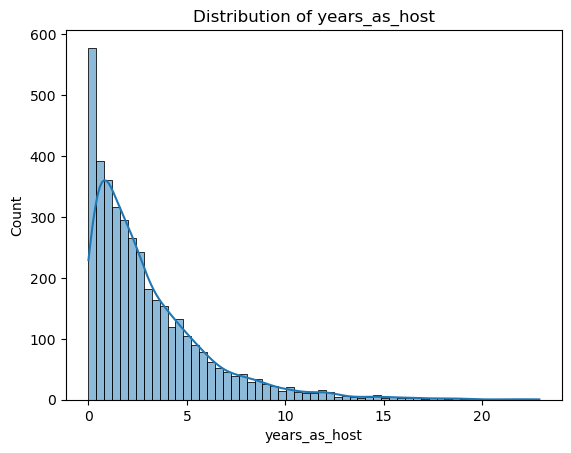

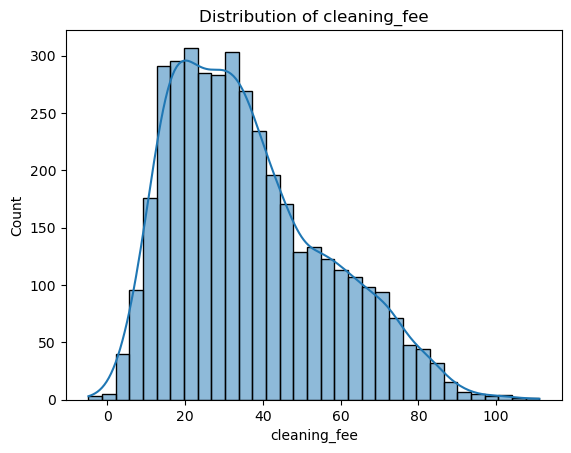

In [ ]:
plot_distributions(df, num_cols)

In [25]:
# Check skewness

skew_check(df, num_cols)

number_of_bedrooms     0.903153
guest_capacity         0.581191
location_score        -0.020977
review_score          -0.165083
amenities_count        0.504965
minimum_stay_nights    0.688846
years_as_host          1.943478
cleaning_fee           0.680534
dtype: float64

In [34]:
"""
High skewness variable: (abs()>0.5)
- number_of_bedrooms : mostly 1 or 2 bedrooms, could be ordinally encoded into 1, 2, 3+
- minimum_stay_nights : could be ordially encoded into 1, 2, 3, 4+
- years_as_host : Log transform
- cleaning_fee : Log transform
"""

# number_of_bedrooms

def bin_bedrooms(x):
    if x == 1:
        return "1"
    elif x == 2:
        return "2"
    else:
        return "3+" 
    
df["bedroom_group"] = df["number_of_bedrooms"].apply(bin_bedrooms)

# minimum_stay_nights

def bin_min_stay(x):
    if x == 1:
        return "1"
    elif x == 2:
        return "2"
    elif x == 3:
        return "3"
    else:
        return "4+"
    
df["min_stay_group"] = df["minimum_stay_nights"].apply(bin_min_stay)

# years_as_host, cleaning_fee

df["years_as_host_log"] = np.log1p(df["years_as_host"])
df["cleaning_fee_log"] = np.log1p(df["cleaning_fee"])



/opt/homebrew/Caskroom/miniconda/base/envs/ise535_project/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
num_cols_processed = list(set(num_cols) - {"number_of_bedrooms", "minimum_stay_nights", "years_as_host", "cleaning_fee"}) + ["bedroom_encoded", "min_stay_encoded", "years_as_host_log", "cleaning_fee_log"]

In [ ]:
# add processed variable into df
df["bedroom_encoded"] = df["bedroom_group"].map({"1": 0, "2": 1, "3+": 2})
df["min_stay_encoded"] = df["min_stay_group"].map({"1": 0, "2": 1, "3": 2, "4+":3})

replace_cols = {
    "number_of_bedrooms": "bedroom_encoded",
    "minimum_stay_nights": "min_stay_encoded",
    "years_as_host": "years_as_host_log",
    "cleaning_fee": "cleaning_fee_log"
}

df_processed = df.drop(columns=list(replace_cols.keys())).copy()

for old_col, new_col in replace_cols.items():
    df_processed[old_col] = df[new_col] 

In [51]:
skew_check(df_processed, num_cols_processed)

location_score      -0.020977
guest_capacity       0.581191
amenities_count      0.504965
review_score        -0.165083
bedroom_encoded      0.256906
min_stay_encoded     0.326179
years_as_host_log    0.256794
cleaning_fee_log    -0.649864
dtype: float64

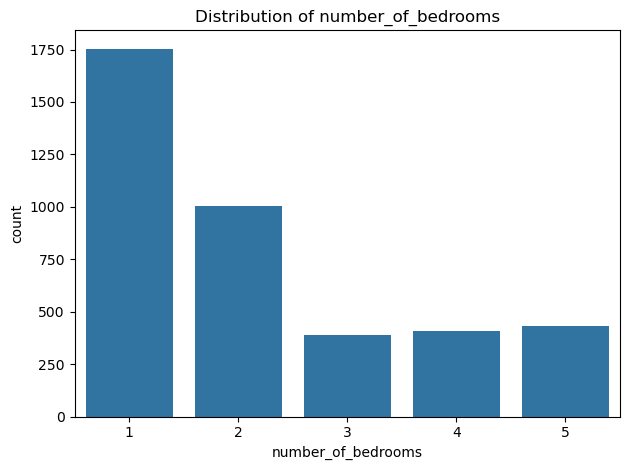

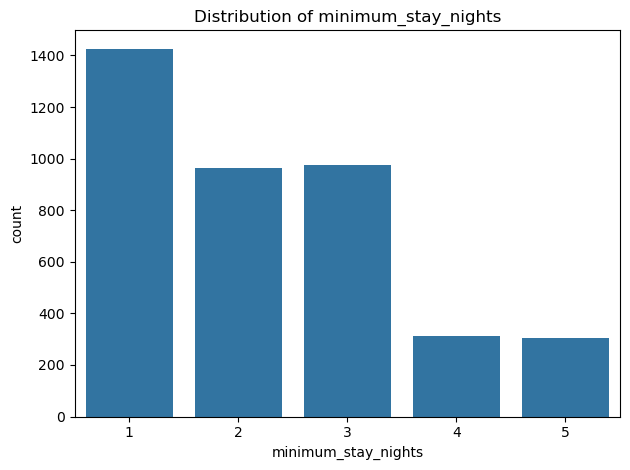

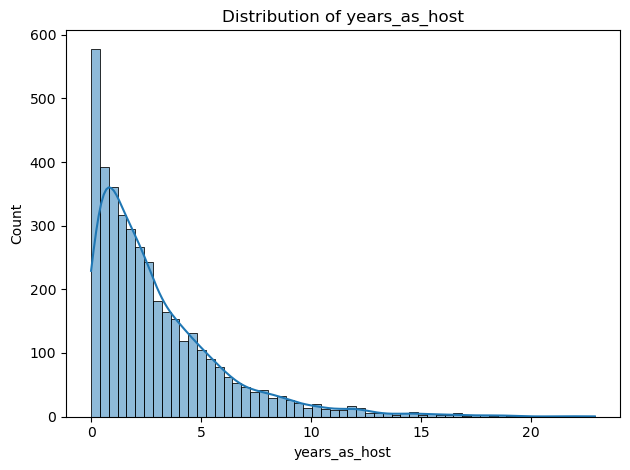

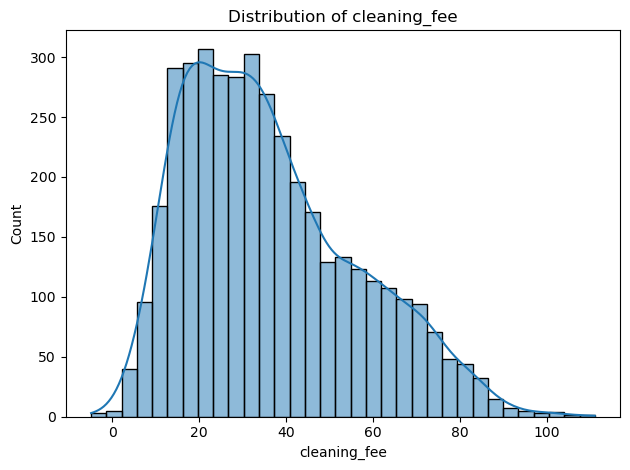

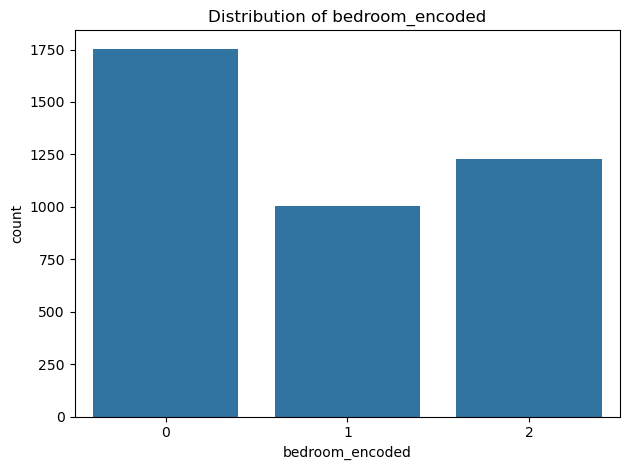

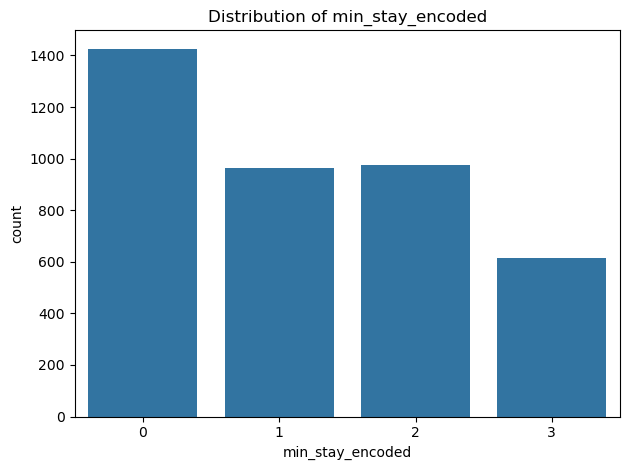

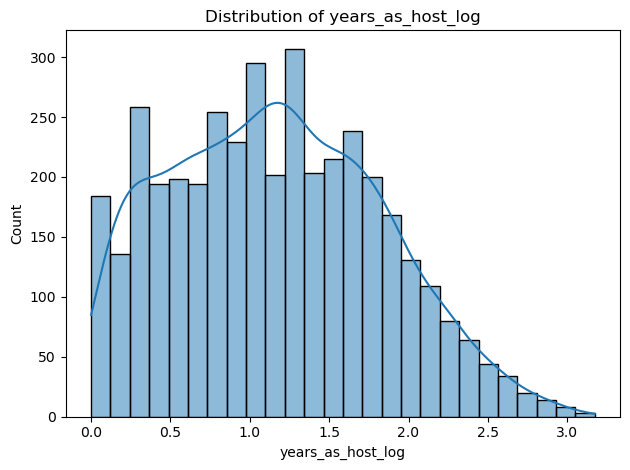

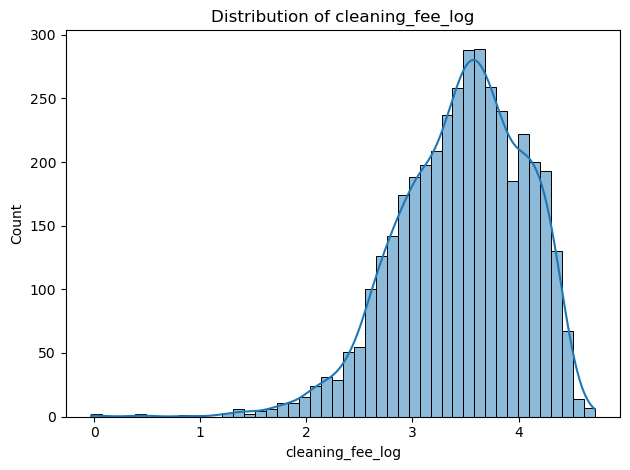

In [57]:
original_high_skew_cols = ["number_of_bedrooms", "minimum_stay_nights", "years_as_host", "cleaning_fee"]
processed_high_skew_cols = ["bedroom_encoded", "min_stay_encoded", "years_as_host_log", "cleaning_fee_log"]
plot_distributions(df[original_high_skew_cols], original_high_skew_cols)
plot_distributions(df[processed_high_skew_cols], processed_high_skew_cols)


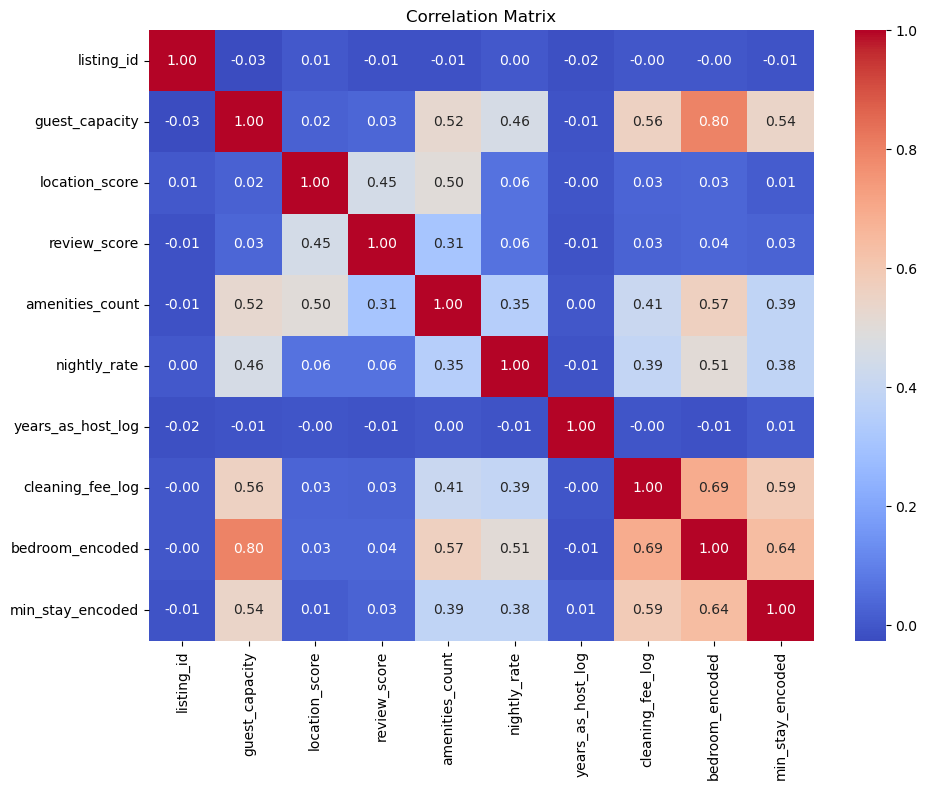

In [69]:
# Correlation Matrix
df_processed = df_processed.drop(columns=original_high_skew_cols)
plot_correlations(df_processed)

### Categorical Columns

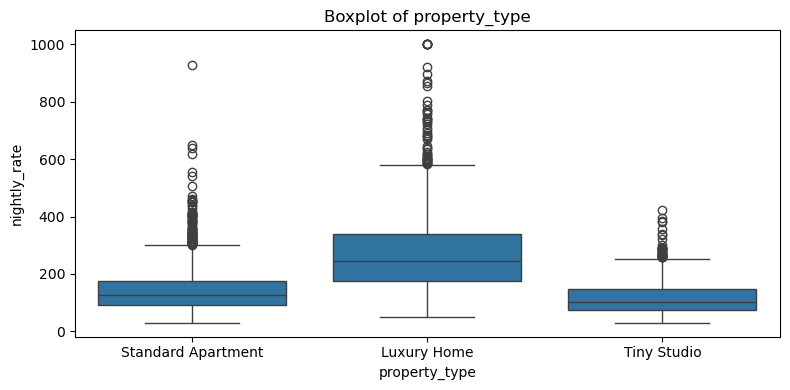

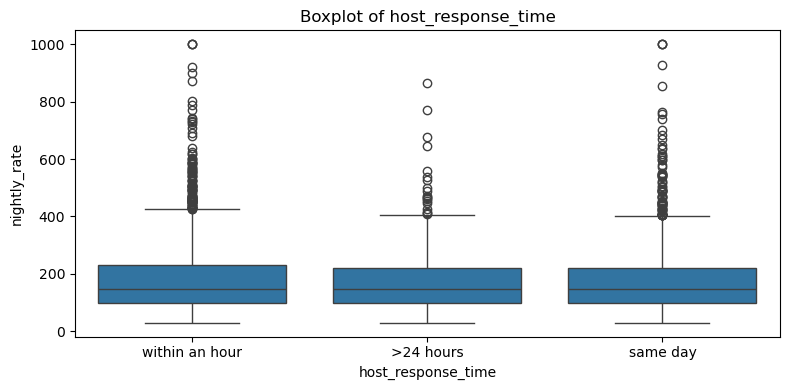

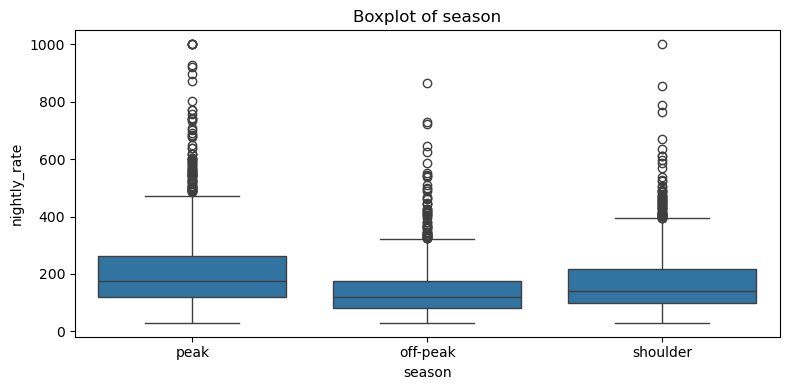

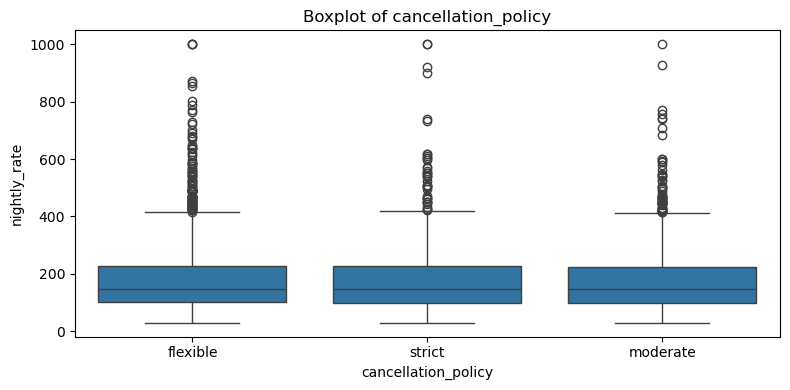

In [31]:
plot_boxplots(df, cat_cols, target)

In [ ]:
"""

"""